In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Homework 1

Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/1PxSEPrUvbOdLw4oR6K3poPNcUFwahzGX/Homework 1


# Libraries

In [2]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [3]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [4]:
# Import other libraries
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

In [5]:
from keras import applications
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model, Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.callbacks import EarlyStopping

# Data import

In [6]:
data = np.load('public_data.npz', allow_pickle=True)
X = data['data']
y= data['labels']
X=(X/255).astype(np.float32)
print(np.shape(X))
print(np.shape(y))
classnames, y = np.unique(y, return_inverse=True)
y= tfk.utils.to_categorical(y,2)


(5200, 96, 96, 3)
(5200,)


In [7]:
#Number of images to display
#num_img = 200

#Create subplots for displaying items
#fig, axes = plt.subplots(40, num_img//40, figsize=(20, 36))
#for i in range(num_img):
#    ax = axes[i%40, i%num_img//40]
#    ax.imshow(np.clip(X[i], 0, 255))  # Display clipped item images
#    ax.axis('off')
#plt.tight_layout()
#plt.show()

In [8]:
#plt.imshow(np.clip(X[2150],0,255))
#plt.imshow(np.clip(X[58],0,255))

In [9]:
# cleaning images from trol and shrek
ref_img = X[58]
ref_img2 = X[2150]
c = 0
c2 = 0
rm_indexes = []
rm2_indexes = []
for i in range(0, len(X)):
    deviation = np.mean(np.abs(ref_img - X[i]))
    deviation2 = np.mean(np.abs(ref_img2 - X[i]))
    if(deviation == 0.0):
        #print(i)
        c += 1
        rm_indexes.append(i)
    elif(deviation2 == 0.0):
        c2 += 1
        rm2_indexes.append(i)

X = np.delete(X, rm_indexes + rm2_indexes, axis=0)
y = np.delete(y, rm_indexes + rm2_indexes, axis=0)
print(X.shape)

(5004, 96, 96, 3)


In [10]:
pip install imagehash

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 6.2 MB/s eta 0:00:00


In [11]:
#ALTERNATIVE CODE TO REMOVE SHREK AND TROLL
#try to see if 5004 images remain
from PIL import Image
import imagehash

# Assuming X contains image paths or image arrays
ref_img_index1 = 58
ref_img_index2 = 2150

# Convert the array to uint8 if not already in that format
img_1 = (X[ref_img_index1] * 255).astype(np.uint8)
img_2 = (X[ref_img_index2] * 255).astype(np.uint8)

hash_1 = imagehash.average_hash(Image.fromarray(img_1))
hash_2 = imagehash.average_hash(Image.fromarray(img_2))

rm_indexes = [ref_img_index1]
rm2_indexes = [ref_img_index2]

for i in range(len(X)):
    if i != ref_img_index1 and imagehash.average_hash(Image.fromarray((X[i] * 255).astype(np.uint8))) == hash_1:
        rm_indexes.append(i)
    elif i != ref_img_index2 and imagehash.average_hash(Image.fromarray((X[i] * 255).astype(np.uint8))) == hash_2:
        rm2_indexes.append(i)

# Removing identical images
rm_indexes = list(set(rm_indexes))  # Remove duplicates
rm2_indexes = list(set(rm2_indexes))  # Remove duplicates

indexes_to_remove = rm_indexes + rm2_indexes

X = np.delete(X, indexes_to_remove, axis=0)
y = np.delete(y, indexes_to_remove, axis=0)

print(X.shape)

(5002, 96, 96, 3)


In [12]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=seed, test_size=0.1, stratify=y)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

X_train shape: (4501, 96, 96, 3), y_train shape: (4501, 2)
X_val shape: (501, 96, 96, 3), y_val shape: (501, 2)


# Set parameters

In [13]:
# dimensions of our images
#img_width, img_height = 96, 96

# set parameters
batch_size = 64
epochs = 150
epochs_tl=30
#num_classes = 2
#activation = 'relu'
#min_delta=0
#patience=20
#dropout=0.2
#lr=1e-4
#earlystopping and learning rate reduction
callbacks=[
    tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=30, restore_best_weights=True, mode='max'),
    tfk.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.1, patience=15, min_lr=1e-5, mode='max')
    ]

# ConvNeXtBase

In [ ]:
#we apply the transformations only to the training set
train_datagen =  ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    #fill_mode='nearest'
)

valid_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(
  X_train,y_train,
  batch_size=batch_size,
)
validation_generator = valid_datagen.flow(
  X_val,y_val,
  batch_size=batch_size,
)

In [ ]:
base_model = tfk.applications.ConvNeXtBase(weights='imagenet', include_top=False,input_shape=(96,96,3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

350926856/350926856 [==============================] - 2s 0us/step


In [ ]:
#transfer learning:
for layer in base_model.layers:
  layer.trainable = False
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_generator,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = validation_generator,
    callbacks = callbacks
).history

KeyboardInterrupt: ignored

In [ ]:
model.save('ConvNeXt_tl_Augmentation_248')

In [ ]:
model=tfk.models.load_model('ConvNeXt_tl_4Augmentation')

In [ ]:
#fine tuning:
for layer in model.layers[:196]:
    layer.trainable = False
for layer in model.layers[196:]:
    layer.trainable = True
model.compile(optimizer='adam',
             loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history = model.fit(train_generator,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = validation_generator,
    callbacks = callbacks
).history

In [ ]:
model.save('ConvNeXt_ft_Augmentation_196')

In [ ]:
#Predict labels for the entire validation set
predictions = model.predict(X_val, verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

#print(predictions)
#print(np.argmax(predictions, axis=-1))
#print(np.shape(np.argmax(predictions, axis=-1)))                       # RMK.
# l'accuracy è la frazione di campioni correttamente classificati
# recall = TP / TP + FN -> misura la frazione di positivi individuati sul totale dei positivi, se è basso significa che il modello assegna zero con troppa facilità, probabilmente ciò è dovuto al dataset imbalance: forse si potrebbe sistemare con data augmentation.... -> todo
# precision = TP / TP + FP -> misura la frazione di positivi veri tra i positivi individuati, è relativamente buona, anche se non abbastanza

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
labels = {0:'Zero', 1:'One'}
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels=list(labels.values()), yticklabels=list(labels.values()), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

# ConvNeXtLarge

In [14]:
#we apply the transformations only to the training set
train_datagen =  ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    #fill_mode='nearest'
)

valid_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(
  X_train,y_train,
  batch_size=batch_size,
)
validation_generator = valid_datagen.flow(
  X_val,y_val,
  batch_size=batch_size,
)

In [15]:
base_model = tfk.applications.ConvNeXtLarge(weights='imagenet', include_top=False,input_shape=(96,96,3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

785596384/785596384 [==============================] - 9s 0us/step


In [16]:
#transfer learning:
for layer in base_model.layers:
  layer.trainable = False
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
history = model.fit(train_generator,
    batch_size = batch_size,
    epochs = epochs_tl,
    validation_data = validation_generator,
    callbacks = callbacks
).history

Epoch 1/30
71/71 [==============================] - 64s 620ms/step - loss: 0.5668 - accuracy: 0.7047 - val_loss: 0.5372 - val_accuracy: 0.7465 - lr: 0.0010
Epoch 2/30
71/71 [==============================] - 31s 438ms/step - loss: 0.5669 - accuracy: 0.7072 - val_loss: 0.5486 - val_accuracy: 0.7505 - lr: 0.0010
Epoch 3/30
71/71 [==============================] - 33s 470ms/step - loss: 0.5709 - accuracy: 0.7030 - val_loss: 0.5424 - val_accuracy: 0.7445 - lr: 0.0010
Epoch 4/30
71/71 [==============================] - 34s 475ms/step - loss: 0.5680 - accuracy: 0.7067 - val_loss: 0.5396 - val_accuracy: 0.7525 - lr: 0.0010
Epoch 5/30
71/71 [==============================] - 32s 443ms/step - loss: 0.5611 - accuracy: 0.7125 - val_loss: 0.5418 - val_accuracy: 0.7525 - lr: 0.0010
Epoch 6/30
71/71 [==============================] - 32s 448ms/step - loss: 0.5682 - accuracy: 0.7150 - val_loss: 0.5467 - val_accuracy: 0.7385 - lr: 0.0010
Epoch 7/30
71/71 [==============================] - 32s 444ms/st

In [25]:
model.save('ConvNeXt_Large_transferlearning')

In [19]:
model=tfk.models.load_model('./development_models/ConvNeXt_Large_transferlearning')

In [26]:
tfk.utils.plot_model(model, show_shapes=True)
for i, layer in enumerate(model.layers):
   print(i, layer.name, layer.trainable)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.991377 to fit

0 input_3 False
1 convnext_large_prestem_normalization False
2 convnext_large_stem False
3 convnext_large_stage_0_block_0_depthwise_conv False
4 convnext_large_stage_0_block_0_layernorm False
5 convnext_large_stage_0_block_0_pointwise_conv_1 False
6 convnext_large_stage_0_block_0_gelu False
7 convnext_large_stage_0_block_0_pointwise_conv_2 False
8 convnext_large_stage_0_block_0_layer_scale False
9 convnext_large_stage_0_block_0_identity False
10 tf.__operators__.add_72 False
11 convnext_large_stage_0_block_1_depthwise_conv False
12 convnext_large_stage_0_block_1_layernorm False
13 convnext_large_stage_0_block_1_pointwise_conv_1 False
14 convnext_large_stage_0_block_1_gelu False
15 convnext_large_stage_0_block_1_pointwise_conv_2 False
16 convnext_large_stage_0_block_1_layer_scale False
17 convnext_large_stage_0_block_1_identity False
18 tf.__operators__.add_73 False
19 convnext_large_stage_0_block_2_depthwis

In [21]:
#fine tuning:
for layer in model.layers[:156]:
    layer.trainable = False
for layer in model.layers[156:]:
    layer.trainable = True
model.compile(optimizer='adam',
             loss='categorical_crossentropy',metrics=['accuracy'])

In [22]:
history = model.fit(train_generator,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = validation_generator,
    callbacks = callbacks
).history

Epoch 1/150
71/71 [==============================] - 101s 881ms/step - loss: 0.9441 - accuracy: 0.6168 - val_loss: 0.6656 - val_accuracy: 0.6188 - lr: 0.0010
Epoch 2/150
71/71 [==============================] - 54s 761ms/step - loss: 0.6679 - accuracy: 0.6196 - val_loss: 0.6659 - val_accuracy: 0.6188 - lr: 0.0010
Epoch 3/150
71/71 [==============================] - 55s 773ms/step - loss: 0.6667 - accuracy: 0.6196 - val_loss: 0.6645 - val_accuracy: 0.6188 - lr: 0.0010
Epoch 4/150
71/71 [==============================] - 57s 803ms/step - loss: 0.6691 - accuracy: 0.6161 - val_loss: 0.6646 - val_accuracy: 0.6188 - lr: 0.0010
Epoch 5/150
71/71 [==============================] - 55s 772ms/step - loss: 0.6665 - accuracy: 0.6196 - val_loss: 0.6668 - val_accuracy: 0.6188 - lr: 0.0010
Epoch 6/150
71/71 [==============================] - 56s 793ms/step - loss: 0.6658 - accuracy: 0.6196 - val_loss: 0.6654 - val_accuracy: 0.6188 - lr: 0.0010
Epoch 7/150
71/71 [==============================] - 54s 

In [23]:
model.save('ConvNeXtLarge_finetuning_156')

Predictions Shape: (501, 2)
Accuracy: 0.6188
Precision: 0.3094
Recall: 0.5
F1: 0.3822


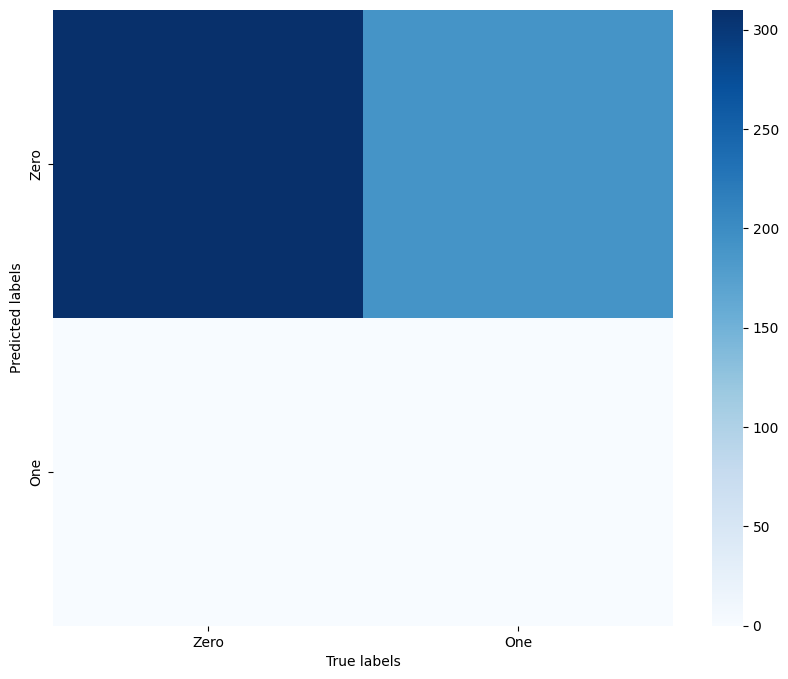

In [24]:
#Predict labels for the entire validation set
predictions = model.predict(X_val, verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

#print(predictions)
#print(np.argmax(predictions, axis=-1))
#print(np.shape(np.argmax(predictions, axis=-1)))                       # RMK.
# l'accuracy è la frazione di campioni correttamente classificati
# recall = TP / TP + FN -> misura la frazione di positivi individuati sul totale dei positivi, se è basso significa che il modello assegna zero con troppa facilità, probabilmente ciò è dovuto al dataset imbalance: forse si potrebbe sistemare con data augmentation.... -> todo
# precision = TP / TP + FP -> misura la frazione di positivi veri tra i positivi individuati, è relativamente buona, anche se non abbastanza

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
labels = {0:'Zero', 1:'One'}
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels=list(labels.values()), yticklabels=list(labels.values()), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()